# Описание данных

- *EventName* — название события;
- *DeviceIDHash* — уникальный идентификатор пользователя;
- *EventTimestamp* — время события;
- *ExpId* — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### План анализа:

1. Загрузить необходимые библиотеки и датасет
2. Подготовить данные
3. Изучить и проверить данные
4. Изучить воронку событий
5. Изучить результаты эксперимента
6. Общий вывод

<a id="upload"></a>
# 1. Загрузить необходимые библиотеки и датасет

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import numpy as np
import seaborn as sns
from scipy import stats as st
import math as mth

In [2]:
# прочитаем файл logs_exp.csv
logs = pd.read_csv('logs_exp.csv', sep='\t')
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
# изучим общую информацию
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
# проверим названия столбцов
logs.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

In [5]:
# проверим дубликаты
logs.duplicated().sum()

413

In [6]:
logs.EventName.unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

#### Вывод

- Датасет `logs_exp` загружен как `logs`;
- Общая информация показала, что датасет состоит из 4 столбцов и 244126;
- В данных обнаружено 413 строк-дубликатов;
- Названия столбцов необходимо переименовать;
- Столбец со временем необходимо привести к другому типу.

<a id="prepare"></a>
# 2. Подготовить данные

In [7]:
# переименуем столбцы
print(logs.columns)
logs.columns = ['event', 'id', 'timestamp', 'test_group']
logs.head()

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')


,event,id,timestamp,test_group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [8]:
# проверим пропуски
logs.isna().sum()

event         0
id            0
timestamp     0
test_group    0
dtype: int64

In [9]:
# избавимся от дубликатов, которые были найдены на предыдущем этапе
logs = logs.drop_duplicates()
logs.duplicated().sum()

0

In [10]:
# проверим типы данных
logs.dtypes

event         object
id             int64
timestamp      int64
test_group     int64
dtype: object

In [11]:
# добавим столбец с датой и временем
logs['datetime'] = pd.to_datetime(logs.timestamp, unit='s')
logs.head()

,event,id,timestamp,test_group,datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


In [12]:
# добавим столбец с датой
logs['date'] = logs['datetime'].dt.date
logs.head()

,event,id,timestamp,test_group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [13]:
logs.dtypes

event                 object
id                     int64
timestamp              int64
test_group             int64
datetime      datetime64[ns]
date                  object
dtype: object

#### Вывод

- В датасете переименованы столбцы на 'event', 'id', 'timestamp', 'test_group';
- Пропущенных значений нет;
- Дубликаты составили меньше 0.2%, поэтому были удалены из общего датасета;
- Добавлены столбцы **datetime** (дата и время) и **date** (дата).

<a id="check"></a>
# 3. Изучить и проверить данные

In [14]:
# узнаем, какие события записаны в логи
logs.event.value_counts().to_frame()

,event
MainScreenAppear,119101
OffersScreenAppear,46808
CartScreenAppear,42668
PaymentScreenSuccessful,34118
Tutorial,1018


In [15]:
# узнаем, сколько всего событий
len(logs.event)

243713

In [16]:
# узнаем, сколько уникальных пользователей
len(logs.id.unique())

7551

In [18]:
# посчитаем среднее количество событий на пользователя
logs.groupby('id')['event'].count().mean()

32.27559263673685

In [19]:
# найдем минимальную и максимальную даты
logs.datetime.agg(['min', 'max'])

min   2019-07-25 04:43:36
max   2019-08-07 21:15:17
Name: datetime, dtype: datetime64[ns]

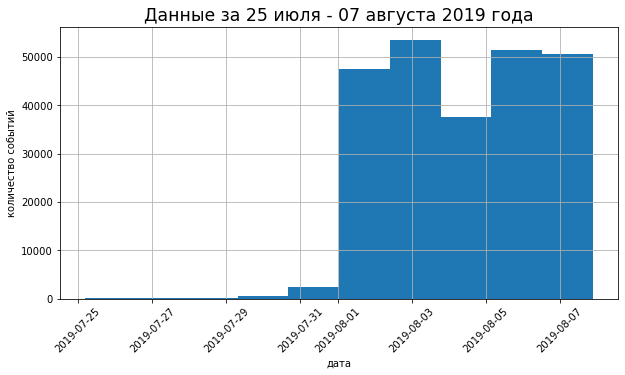

In [20]:
# импортируем конвертер, чтобы pandas не выдавал предупреждений
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# гистограмма данных за весь период
plt.figure(figsize=(10, 5))
logs.datetime.hist()
plt.title('Данные за 25 июля - 07 августа 2019 года', fontsize='xx-large')
plt.xlabel('дата')
plt.ylabel('количество событий')
plt.xticks(rotation=45)
plt.show()

- На гистограмме показаны данные за период 2019-07-25 04:43:36 - 2019-08-07 21:15:17;
- Исходя из визуализации, выделим основной период исследования полученных данных - с 1 августа 2019, начиная с 00:00:00;
- Возможная причина смещения данных - технические особенности выгрузки.

In [21]:
# оставим даты от 1 августа включительно
logs_new = logs[logs['datetime'] >= '2019-08-01 00:00:00']
logs_new.head()

,event,id,timestamp,test_group,datetime,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [22]:
# проверим последние события полученного датасета
logs_new.tail()

,event,id,timestamp,test_group,datetime,date
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07
244125,OffersScreenAppear,5746969938801999050,1565212517,246,2019-08-07 21:15:17,2019-08-07


In [23]:
# создадим переменную с общим количеством уникальных пользователей в новом датасете
initial = len(logs_new.id.unique())
initial

7534

In [24]:
print('Число уникальных пользователей:', initial)
print('Количество событий:', len(logs_new.event))
print('Среднее количество событий на одного пользователя в новом датасете:', round(len(logs_new.event) / initial))
print('Количество удаленных логов:', len(logs.event) - len(logs_new.event))

Число уникальных пользователей: 7534
Количество событий: 240887
Среднее количество событий на одного пользователя в новом датасете: 32
Количество удаленных логов: 2826


In [25]:
print('Контрольная группа 246:', len(logs_new.query('test_group == 246')['id'].unique()))
print('Контрольная группа 247:', len(logs_new.query('test_group == 247')['id'].unique()))
print('Экспериментальная группа 248:', len(logs_new.query('test_group == 248')['id'].unique()))

Контрольная группа 246: 2484
Контрольная группа 247: 2513
Экспериментальная группа 248: 2537


#### Вывод

- Изначально в датасете `logs` собрано 243713 событий для 7551 уникального пользователя;
- На каждого пользователя приходилось в среднем 32 события;
- После анализа гистограммы мы выделили особенности:
    - На гистограмме показаны данные за период 2019-07-25 04:43:36 - 2019-08-07 21:15:17;
    - Исходя из визуальзации, выделим основной период исследования полученных данных - с 1 августа 2019, начиная с 00:00:00;
    - Возможная причина смещения данных - технические особенности выгрузки.
- Таким образом, мы взяли данные за период с **01 по 07 августа 2019 года** и сохранили их в датасете **`logs_new`**, удалив 2826 строку, в итоге:
    - Число уникальных пользователей равно 7534;
    - Количество событий - 240887;
    - Среднее количество событий осталось примерно таким же - 32.
- **Количество удаленных событий = 2826, количество удаленных пользователей = 17**
- В датасете `logs_new` собраны данные всех трех экспериментальных групп - 246, 247 и 248;
- Следующий шаг работы с данными - анализ воронки событий.

<a id="funnel"></a>
# 4. Изучить воронку событий

In [26]:
# рассмотрим частоту событий
logs_new.event.value_counts().to_frame()

,event
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [27]:
# посчитаем, сколько уникальных пользователей совершали каждое событие
unique_users = logs_new.groupby('event').agg({'id': 'nunique'}).sort_values(by='id', ascending=False).reset_index()
unique_users

,event,id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [28]:
# узнаем долю пользователей, совершивших событие хотя бы раз
unique_users['part'] = round((unique_users['id'] / initial), 2)
unique_users

,event,id,part
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


In [29]:
# создадим предполагаемую последовательность событий, исключив Tutorial как опциональный
sequence = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

In [30]:
# сохраним таблицу без строки Tutorial
unique_users = unique_users.query('event == @sequence')
unique_users

,event,id,part
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47


In [31]:
# исключим шаг Tutorial из датасета и создадим новый
funnel = logs_new.query('event == @sequence')
funnel.event.unique()

array(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful'], dtype=object)

In [32]:
funnel.groupby('event').agg({'id': 'count'}).sort_values(by='id', ascending=False)

,id
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918


In [33]:
# создадим таблицу с первыми событиями каждого пользователя
first_event = funnel.pivot_table(index='id', columns='event', values='datetime', aggfunc='min')
first_event.head()

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
id,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45


In [34]:
# узнаем, сколько пользователей открыли главный экран
first_event[~first_event['MainScreenAppear'].isna()].shape[0]

7419

In [35]:
# зададим последовательность событий в воронке, используя строгое неравенство
step1 = ~first_event['MainScreenAppear'].isna()
step2 = step1 & (first_event['OffersScreenAppear'] > first_event['MainScreenAppear'])
step3 = step2 & (first_event['CartScreenAppear'] > first_event['OffersScreenAppear'])
step4 = step3 & (first_event['PaymentScreenSuccessful'] > first_event['CartScreenAppear'])

In [37]:
# посчитаем количество пользователей на каждом этапе
n_MainScreen = first_event[step1].shape[0]
n_OffersScreen = first_event[step2].shape[0]
n_CartScreen = first_event[step3].shape[0]
n_PaymentScreen = first_event[step4].shape[0]

print(n_MainScreen, 'посетителей')
print(n_OffersScreen, 'открыли спецпредложения')
print(n_CartScreen, 'добавили в корзину')
print(n_PaymentScreen, 'оплатили')

7419 посетителей
4201 открыли спецпредложения
1767 добавили в корзину
454 оплатили


In [38]:
# проведем нестрогое сравнение двух последних этапов
step4_test = step3 & (first_event['PaymentScreenSuccessful'] >= first_event['CartScreenAppear'])
n_PaymentScreen_test = first_event[step4_test].shape[0]
print(n_PaymentScreen_test, 'оплатили')

1338 оплатили


In [39]:
# посчитаем, какой процент переходит на следующий шаг
print('Доля пользователей, открывших главный экран: {:.2%}'.format(n_MainScreen / len(logs_new.id.unique())))
print('Доля пользователей, перешедших к предложениям: {:.2%}'.format(n_OffersScreen / n_MainScreen))
print('Доля пользователей, перешедших к корзине: {:.2%}'.format(n_CartScreen / n_OffersScreen))
print('Доля пользователей, совершивших оплату: {:.2%}'.format(n_PaymentScreen / n_CartScreen))

Доля пользователей, открывших главный экран: 98.47%
Доля пользователей, перешедших к предложениям: 56.62%
Доля пользователей, перешедших к корзине: 42.06%
Доля пользователей, совершивших оплату: 25.69%


In [40]:
# посчитаем долю пользователей, дошедших от первого события до оплаты
print('Доля пользователей, дошедших от первого события до оплаты: {:.2%}'.format(n_PaymentScreen / n_MainScreen))

Доля пользователей, дошедших от первого события до оплаты: 6.12%


In [41]:
# загрузим дополнительный параметр для отображения графика
import plotly.offline as py
py.init_notebook_mode(connected=True)

# построим воронку событий
fig = go.Figure(go.Funnel(
    y = ["Посетители", "Открыли предложения", "Добавили в корзину", "Оплатили"],
    x = [7419, 4201, 1767, 454]))
fig.update_layout(title_text='Воронка событий')
fig.show()

 Изображение на Google Drive на случай, если не отображается график: <a href="https://drive.google.com/file/d/1VYb4qYEsv0gtnouQB-1RUbjvlgYY59RG/view?usp=sharing">Ссылка на диск</a>

### Вывод

- В датасете `logs_new` содержится 5 типов события: 'MainScreenAppear' (произошло 117328 раз), 'OffersScreenAppear' (46333), 'CartScreenAppear' (42303), 'PaymentScreenSuccessful' (33918) и 'Tutorial' (1005);
- Вероятная продуктовая воронка с учетом последовательности событий: 1. MainScreenAppear, 2. OffersScreenAppear, 3. CartScreenAppear, 4. PaymentScreenSuccessful;
- Событие 'Tutorial' было исключено как самое малочисленное и опциональное;
- Если анализировать посетителей, совершивших каждое событие, данные представлены так:
    - MainScreenAppear - 7419,
    - OffersScreenAppear - 4593,
    - CartScreenAppear - 3734,
    - PaymentScreenSuccessful - 3539
- Мы рассчитали долю пользователей, переходивших с этапа на этап (**доля от предыдущего события**):
    - MainScreenAppear = 98,47%,
    - OffersScreenAppear = 56.62%,
    - CartScreenAppear = 42.06%,
    - PaymentScreenSuccessful = 25.69%,
- Больше всего пользователей компания теряет на шаге *OffersScreenAppear* (доходит около 57%), 
- Доля пользователей, дошедших от первого события до оплаты: 6,12%.
- Однако до шага PaymentScreenSuccessful за рассматриваемый период дошло 3539 пользователей, т.е. 47% от изначального. Вероятно, часть пользователей шли другим путем, а не по представленной воронке. Например, при нестрогом сравнении по времени PaymentScreenSuccessful и CartScreenAppear оплачивают заказы 1338 пользователей.

<a id="experiment"></a>
# 5. Изучить результаты эксперимента

#### Размеры трех групп

In [40]:
# создадим переменные для количества уникальных пользователей в трех группах без учета Tutorial
initial_246 = len(funnel.query('test_group == 246')['id'].unique())
initial_247 = len(funnel.query('test_group == 247')['id'].unique())
initial_248 = len(funnel.query('test_group == 248')['id'].unique())

In [41]:
# количество пользователей в группах 
print('Контрольная группа 246:', initial_246)
print('Контрольная группа 247:', initial_247)
print('Экспериментальная группа 248:', initial_248)

Контрольная группа 246: 2483
Контрольная группа 247: 2512
Экспериментальная группа 248: 2535


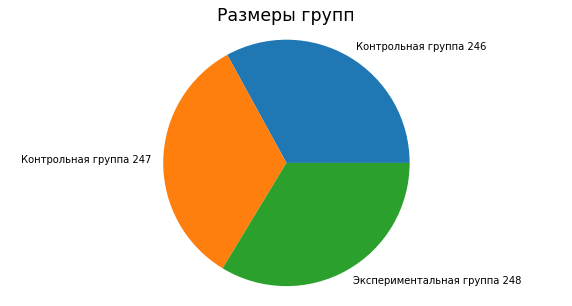

In [42]:
# отразим на круговой диаграмме, как распределились группы
labels = 'Контрольная группа 246', 'Контрольная группа 247', 'Экспериментальная группа 248'
sizes = [initial_246, initial_247, initial_248]
fig_pie, ax_pie = plt.subplots(figsize=(10,5))
ax_pie.pie(sizes, labels=labels)
ax_pie.axis('equal')
plt.title('Размеры групп', fontsize='xx-large')
plt.show()

- Контрольная группа 246 включает 2483 пользователей;
- Контрольная группа 247 - 2512;
- Экспериментальная группа 248 - 2535;
- Из диаграммы видно, что количество групп примерно одинаково;
- Однако необходима статистическая проверка, чтобы проанализировать корректность механизма деления на группы.

In [43]:
# выделим контрольную группу 246
a246 = funnel.query('test_group == 246')
a246.head()

,event,id,timestamp,test_group,datetime,date
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2834,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01 00:10:26,2019-08-01
2835,MainScreenAppear,3737462046622621720,1564618247,246,2019-08-01 00:10:47,2019-08-01


In [44]:
# сгруппируем данные, чтобы посчитать уникальное количество пользователей на каждом шаге и выделим долю
a246_grouped = a246.groupby('event').agg({'id': 'nunique'}).sort_values(by='id', ascending=False).reset_index()
a246_grouped.columns = ['event', 'a246_id']
a246_grouped['a246_part'] = round((a246_grouped['a246_id'] / initial_246), 2)
a246_grouped

,event,a246_id,a246_part
0,MainScreenAppear,2450,0.99
1,OffersScreenAppear,1542,0.62
2,CartScreenAppear,1266,0.51
3,PaymentScreenSuccessful,1200,0.48


In [45]:
# выделим контрольную группу 247
a247 = funnel.query('test_group == 247')
a247.head()

,event,id,timestamp,test_group,datetime,date
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
2833,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01
2838,MainScreenAppear,4899590676214355127,1564618288,247,2019-08-01 00:11:28,2019-08-01
2839,OffersScreenAppear,4899590676214355127,1564618290,247,2019-08-01 00:11:30,2019-08-01
2843,OffersScreenAppear,4899590676214355127,1564618356,247,2019-08-01 00:12:36,2019-08-01


In [46]:
# сгруппируем данные, чтобы посчитать уникальное количество пользователей на каждом шаге и выделим долю
a247_grouped = a247.groupby('event').agg({'id': 'nunique'}).sort_values(by='id', ascending=False).reset_index()
a247_grouped.columns = ['event', 'a247_id']
a247_grouped['a247_part'] = round((a247_grouped['a247_id'] / initial_247), 2)
a247_grouped

,event,a247_id,a247_part
0,MainScreenAppear,2476,0.99
1,OffersScreenAppear,1520,0.61
2,CartScreenAppear,1238,0.49
3,PaymentScreenSuccessful,1158,0.46


In [47]:
# создадим объедненную таблицу по контрольным группам с абсолютными показателями и долями
a_merged = a246_grouped.merge(a247_grouped, on='event', how='left')
a_merged['aa_id'] = a_merged['a246_id'] + a_merged['a247_id']
a_merged['aa_part'] = round(a_merged['aa_id'] / (initial_246 + initial_247), 2)
a_merged

,event,a246_id,a246_part,a247_id,a247_part,aa_id,aa_part
0,MainScreenAppear,2450,0.99,2476,0.99,4926,0.99
1,OffersScreenAppear,1542,0.62,1520,0.61,3062,0.61
2,CartScreenAppear,1266,0.51,1238,0.49,2504,0.50
3,PaymentScreenSuccessful,1200,0.48,1158,0.46,2358,0.47


In [48]:
# проверим, есть ли дубликаты id в двух контрольных группах
e = pd.Series(a246.id.unique())
f = pd.Series(a247.id.unique())
print(len(e))
print(len(f))
joint = pd.concat([e,f])
print(len(joint))
joint.duplicated().sum()

2483
2512
4995


0

In [49]:
# критерии для проверки
print('Разница в количестве пользователей:', abs(initial_246-initial_247))
print('Отличие метрик в процентах:', round((a_merged.a246_part - a_merged.a247_part).mean(), 3))
print('Отличие метрик в абсолютных показателях:', round((abs(a_merged.a246_id - a_merged.a247_id).mean())))

Разница в количестве пользователей: 29
Отличие метрик в процентах: 0.012
Отличие метрик в абсолютных показателях: 30


- Выборки контрольных групп отличаются друг от друга на 29 пользователей, т.е. примерно на 1.17% от минимального количества (2483);
- Доли по каждому шагу в воронке отличаются в группах в среднем на 1.2% и в среднем на 30 пользователей;
- Пользователи разделены на группы, пересечений нет.

In [50]:
# создадим функцию для определения статистически значимых раздичий между выборками, используя z-тест
# alpha зададим при выполнении функции
# нулевая гипотеза: группы не отличаются друг от друга
def z_testing(col1, col2, initial_1, initial_2, alpha):
    success = np.array([col1, col2])
    trial = np.array([initial_1, initial_2])

    # пропорция успехов в первой группе:
    p1 = success[0]/trial[0]
    # пропорция успехов во второй группе:
    p2 = success[1]/trial[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (trial[0] + trial[1])
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в стандартных отклонениях стандартного нормального распределения
    z_value = difference/mth.sqrt(p_combined * (1 - p_combined) * (1/trial[0] + 1/trial[1]))
    # задаем стандартное нормальное распределение (среднее 0, станд.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение:', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
    return '-----------------------------------------------------------------------------'

In [51]:
# выполним функцию для контрольных групп, alpha=0.01
for i in range(0, 4):
    print(z_testing(a_merged.a246_id[i], a_merged.a247_id[i], initial_246, initial_247, 0.01))

p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


- Нулевая гипотеза: равенство долей сравниваемых генеральных совокупностей;
- Альтернативная гипотеза: эти доли разные;
- Уровень значимости alpha=0.01;
- Использование Z-теста для проверки долей выборок показало, что статистически нет оснований считать доли групп 246 и 247 разными;
- На каждом из четырех этапов воронки нет достатоточных оснований, чтобы отвергнуть нулевую гипотезу.

#### Анализ А/А/В теста

In [52]:
# выделим экспериментальную группу 248
b248 = funnel.query('test_group == 248')
b248.head()

,event,id,timestamp,test_group,datetime,date
2844,MainScreenAppear,4613461174774205834,1564618471,248,2019-08-01 00:14:31,2019-08-01
2845,MainScreenAppear,4613461174774205834,1564618474,248,2019-08-01 00:14:34,2019-08-01
2846,CartScreenAppear,4613461174774205834,1564618474,248,2019-08-01 00:14:34,2019-08-01
2847,PaymentScreenSuccessful,4613461174774205834,1564618483,248,2019-08-01 00:14:43,2019-08-01
2848,OffersScreenAppear,4613461174774205834,1564618491,248,2019-08-01 00:14:51,2019-08-01


In [53]:
# сгруппируем данные, чтобы посчитать уникальное количество пользователей на каждом шаге и выделим долю
b248_grouped = b248.groupby('event').agg({'id': 'nunique'}).sort_values(by='id', ascending=False).reset_index()
b248_grouped.columns = ['event', 'b248_id']
b248_grouped['b248_part'] = round((b248_grouped['b248_id'] / initial_248), 2)
b248_grouped

,event,b248_id,b248_part
0,MainScreenAppear,2493,0.98
1,OffersScreenAppear,1531,0.60
2,CartScreenAppear,1230,0.49
3,PaymentScreenSuccessful,1181,0.47


In [54]:
# объединим таблицы с А/А и В группами
ab_merged = a_merged.merge(b248_grouped, on='event', how='left')
ab_merged

,event,a246_id,a246_part,a247_id,a247_part,aa_id,aa_part,b248_id,b248_part
0,MainScreenAppear,2450,0.99,2476,0.99,4926,0.99,2493,0.98
1,OffersScreenAppear,1542,0.62,1520,0.61,3062,0.61,1531,0.60
2,CartScreenAppear,1266,0.51,1238,0.49,2504,0.50,1230,0.49
3,PaymentScreenSuccessful,1200,0.48,1158,0.46,2358,0.47,1181,0.47


In [55]:
# проверим нулевую гипотезу о равенстве долей для групп 246 и 248
for i in range(0, 4):
    print(z_testing(ab_merged.a246_id[i], ab_merged.b248_id[i], initial_246, initial_248, 0.01))

p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


In [56]:
# проверим гипотезу о равенстве долей для групп 247 и 248
for i in range(0, 4):
    print(z_testing(ab_merged.a247_id[i], ab_merged.b248_id[i], initial_247, initial_248, 0.01))

p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


In [57]:
# проверим гипотезу о равенстве долей для объединенных А/А групп и группы 248
for i in range(0, 4):
    print(z_testing(ab_merged.aa_id[i], ab_merged.b248_id[i], (initial_246+initial_247), initial_248, 0.01))

p-значение: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


- Применение Z-теста к проверке нулевой гипотезы о равенстве долей показало, что доли (группы) статистически значимо не отличаются, т.е. эксперимент проведен корректно;
- Критический уровень значимости взят минимальным и равен 1%;
- Гипотеза суммарно проверялась 16 раз (4 раза на контрольных группах и 12 раз на разных группах), поэтому необходимо учесть **множесвенный тест** на одних и тех же данных.

#### Изменение уровня статистической значимости

In [58]:
# проверим нулевую гипотезу о равенстве долей для групп 246 и 247, alpha=0.1
for i in range(0, 4):
    print(z_testing(a_merged.a246_id[i], a_merged.a247_id[i], initial_246, initial_247, 0.1))

p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


In [59]:
# проверим нулевую гипотезу о равенстве долей для групп 246 и 248, alpha=0.1
for i in range(0, 4):
    print(z_testing(ab_merged.a246_id[i], ab_merged.b248_id[i], initial_246, initial_248, 0.1))

p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.08067367598823139
Отвергаем нулевую гипотезу: между долями есть значимая разница
-----------------------------------------------------------------------------
p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


In [60]:
# проверим гипотезу о равенстве долей для групп 247 и 248, alpha=0.1
for i in range(0, 4):
    print(z_testing(ab_merged.a247_id[i], ab_merged.b248_id[i], initial_247, initial_248, 0.1))

p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


In [61]:
# проверим гипотезу о равенстве долей для объединенных А/А групп и группы 248, alpha=0.1
for i in range(0, 4):
    print(z_testing(ab_merged.aa_id[i], ab_merged.b248_id[i], (initial_246+initial_247), initial_248, 0.1))

p-значение: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


- При изменении критического уровня значимости в одном из 16 сравнений тест нашел статистически значимые различия;
- Оптимальным считается уровень, равный 5%, но для более точного теста используют 1%.

#### Применение поправки Бонферрони

In [62]:
# рассчитаем вероятность ошибиться хотя бы раз за 16 попарных сравнений (alpha=0.01)
print('Вероятность ложнопозитивного результата хотя бы в одном из 16 сравнений для alpha=0.01: {:.2%}'.format((1 - (1 - 0.01)**16)))

Вероятность ложнопозитивного результата хотя бы в одном из 16 сравнений для alpha=0.01: 14.85%


In [63]:
# рассчитаем вероятность ошибиться хотя бы раз за 16 попарных сравнений (alpha=0.05)
print('Вероятность ложнопозитивного результата хотя бы в одном из 16 сравнений для alpha=0.05: {:.2%}'.format((1 - (1 - 0.05)**16)))

Вероятность ложнопозитивного результата хотя бы в одном из 16 сравнений для alpha=0.05: 55.99%


In [64]:
# рассчитаем вероятность ошибиться хотя бы раз за 16 попарных сравнений (alpha=0.1)
print('Вероятность ложнопозитивного результата хотя бы в одном из 16 сравнений для alpha=0.1: {:.2%}'.format((1 - (1 - 0.1)**16)))

Вероятность ложнопозитивного результата хотя бы в одном из 16 сравнений для alpha=0.1: 81.47%


In [65]:
# применим поправку Бонферрони для 16 сравнений, уровень значимости равен 5%
# проверим нулевую гипотезу о равенстве долей для групп 246 и 247, alpha=0.05
for i in range(0, 4):
    print(z_testing(a_merged.a246_id[i], a_merged.a247_id[i], initial_246, initial_247, 0.05/16))

p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


In [66]:
# проверим нулевую гипотезу о равенстве долей для групп 246 и 248, alpha=0.05
for i in range(0, 4):
    print(z_testing(ab_merged.a246_id[i], ab_merged.b248_id[i], initial_246, initial_248, 0.05/16))

p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


In [67]:
# проверим гипотезу о равенстве долей для групп 247 и 248, alpha=0.05
for i in range(0, 4):
    print(z_testing(ab_merged.a247_id[i], ab_merged.b248_id[i], initial_247, initial_248, 0.05/16))

p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


In [68]:
# проверим гипотезу о равенстве долей для объединенных А/А групп и группы 248, alpha=0.05
for i in range(0, 4):
    print(z_testing(ab_merged.aa_id[i], ab_merged.b248_id[i], (initial_246+initial_247), initial_248, 0.05/16))

p-значение: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------
p-значение: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
-----------------------------------------------------------------------------


- Мы уменьшили alpha в 16 раз, применив поправку Бонферрони и проверив уровень значимости 5%;
- Т.к. p-value во всех случаях достаточно большое, то изначальные результаты не изменились и во всех сравнениях мы не можем отвергнуть нулевую гипотезу о равенстве долей.
- Однако при анализе вероятности ложнопозитивного результата хотя бы в одном из 16 попарных сравнений для разных уровней значимости отличается значительно:
     - 14.85% для alpha=0.01;
     - 55.99% для alpha=0.05;
     - 81.47% для alpha=0.1.

### Вывод

- На этапе изучения результатов экспериментов мы выделили три группы и создали таблицу с данными по уникальным пользователям на каждом этапе воронки (без учета шага Tutorial)
    - Контрольная группа 246 включает 2483 пользователей;
    - Контрольная группа 247 - 2512;
    - Экспериментальная группа 248 - 2535;
    - Размеры групп представлены на круговой диаграмме (доли примерно одинаковы);
    - Далее мы провели статистическую проверку, позволяющую проанализировать корректность механизма деления на группы.\
- Данные контрольных групп 246 и 247 были проверены по критериям успешности А/А теста:
    - Выборки контрольных групп отличаются друг от друга на 29 пользователей, т.е. примерно на 1.17%;
    - Выделены четыре основных шага воронки и количество уникальных пользователей;
    - Доли по каждому шагу в воронке отличаются в группах в среднем на 1.2% и в среднем на 30 пользователей;
    - Пользователи разделены на группы, пересечений нет.
- Для проверки нулевой гипотезы о равенстве долей была создана функция z_testing, которая сначала проверялась на двух контрольных группах:
    - Z-тест позволяет проверить гипотезу о равентсве настоящих пропорций в сравниваемых генеральных совокупностях;
    - Нулевая гипотеза: равенство долей сравниваемых генеральных совокупностей;
    - Альтернативная гипотеза: эти доли разные;
    - Уровень значимости alpha=0.01, что позволяет уменьшить  ошибку 1 рода (т.е. p-value < alpha);
    - В итоге статистически значимых различий между долями нет ни в одном из 4 сравнений (по количеству шагов воронки).
- Применение Z-теста к проверке нулевой гипотезы о равенстве долей в А/А/В тестировании показало, что доли (группы) статистически значимо не отличаются, т.е. эксперимент проведен корректно;
    - Критический уровень значимости также взят минимальным и равен 1%;
    - Гипотеза суммарно проверялась 16 раз (4 раза на контрольных группах и 12 раз на разных группах), поэтому необходимо учесть **множественный тест** на одних и тех же данных.
- При изменении критического уровня значимости с 0.01 до 0.1 в одном из 16 сравнений тест нашел статистически значимые различия;
- Оптимальным считается уровень, равный 5%, но для более точного теста используют 1%.
- Применение поправки Бонферрони:
    - Мы уменьшили alpha в 16 раз, применив поправку Бонферрони и проверив уровень значимости 5%;
    - Т.к. p-value во всех случаях достаточно большое, то изначальные результаты не изменились и во всех сравнениях мы не можем отвергнуть нулевую гипотезу о равенстве долей.
    - Однако при анализе вероятности ложнопозитивного результата хотя бы в одном из 16 попарных сравнений для разных уровней значимости отличается значительно:
         - 14.85% для alpha=0.01;
         - 55.99% для alpha=0.05;
         - 81.47% для alpha=0.1.
- Таким образом, при множественном тесте необходимо учитывать уровень значимости и применять поправки, чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез.

<a id="conclusion"></a>
# Общий вывод

- Основная **задача** этого проекта - изучить воронку продаж, исследовать результаты А/А/В тестирования и проанализировать итоги.


- В начале загружен и изучен датасет `logs`:
    - Общая информация показала, что датасет состоит из 4 столбцов и 244126;
    - В данных обнаружено 413 строк-дубликатов. Они составили меньше 0.2%, поэтому были удалены из общего датасета;
    - В датасете переименованы столбцы на 'event', 'id', 'timestamp', 'test_group';
    - Пропущенных значений нет; 
    - Добавлены столбцы **datetime** (дата и время) и **date** (дата).
    
    
- Затем проверены и скорректированы данные исходного датасета:
    - Изначально в датасете `logs` собрано 243713 событий для 7551 уникального пользователя;
    - На каждого пользователя приходилось в среднем 32 события;
    - После построения и анализа гистограммы мы выделили особенности:
        - На гистограмме показаны данные за период 2019-07-25 04:43:36 - 2019-08-07 21:15:17;
        - Исходя из визуальзации, выделим основной период исследования полученных данных - с 1 августа 2019, начиная с 00:00:00;
        - Возможная причина смещения данных - технические особенности выгрузки.
    - Таким образом, мы взяли данные за период с **01 по 07 августа 2019 года** и сохранили их в датасете **`logs_new`**, удалив 2826 строку, в итоге:
        - Число уникальных пользователей равно 7534;
        - Количество событий - 240887;
        - Среднее количество событий осталось примерно таким же - 32.
    - **Количество удаленных событий = 2826, количество удаленных пользователей = 17**
    - В датасете `logs_new` собраны данные всех трех экспериментальных групп - 246, 247 и 248;


- В датасете `logs_new` содержится 5 типов события: 'MainScreenAppear' (произошло 117328 раз), 'OffersScreenAppear' (46333), 'CartScreenAppear' (42303), 'PaymentScreenSuccessful' (33918) и 'Tutorial' (1005):
    - Вероятная продуктовая воронка с учетом последовательности событий: 1. MainScreenAppear, 2. OffersScreenAppear, 3. CartScreenAppear, 4. PaymentScreenSuccessful;
    - Событие 'Tutorial' было исключено как самое малочисленное и опциональное;
    - Если анализировать уникальных пользователей, совершивших каждое событие, данные представлены так:
        - MainScreenAppear - 7419,
        - OffersScreenAppear - 4593,
        - CartScreenAppear - 3734,
        - PaymentScreenSuccessful - 3539,
    - Мы рассчитали долю пользователей, переходивших с этапа на этап (**доля от предыдущего события**):
        - MainScreenAppear = 98,47%,
        - OffersScreenAppear = 56.62%,
        - CartScreenAppear = 42.06%,
        - PaymentScreenSuccessful = 25.69%,
    - Больше всего пользователей компания теряет на шаге *OffersScreenAppear* (доходит около 57%), 
    - Доля пользователей, дошедших от первого события до оплаты: 6,12%.
    - Однако до шага PaymentScreenSuccessful за рассматриваемый период дошло 3539 пользователей, т.е. 47% от изначального. Вероятно, часть пользователей шли другим путем, а не по представленной воронке. Например, при нестрогом сравнении (>=) по времени PaymentScreenSuccessful и CartScreenAppear оплачивают заказы 1338 пользователей.
    
    
### Анализ результатов эксперимента

- На этапе изучения результатов экспериментов мы выделили три группы и создали таблицу с данными по уникальным пользователям на каждом этапе воронки (без учета шага Tutorial)
    - Контрольная группа 246 включает 2483 пользователей;
    - Контрольная группа 247 - 2512;
    - Экспериментальная группа 248 - 2535;
    - Размеры групп представлены на круговой диаграмме (доли примерно одинаковы);
    - Далее мы провели статистическую проверку, позволяющую проанализировать корректность механизма деления на группы.\
- Данные контрольных групп 246 и 247 были проверены по критериям успешности А/А теста:
    - Выборки контрольных групп отличаются друг от друга на 29 пользователей, т.е. примерно на 1.17%;
    - Выделены четыре основных шага воронки и количество уникальных пользователей;
    - Доли по каждому шагу в воронке отличаются в группах в среднем на 1.2% и в среднем на 30 пользователей;
    - Пользователи разделены на группы, пересечений нет.
- Для проверки нулевой гипотезы о равенстве долей была создана функция z_testing, которая сначала проверялась на двух контрольных группах:
    - Z-тест позволяет проверить гипотезу о равентсве настоящих пропорций в сравниваемых генеральных совокупностях;
    - Нулевая гипотеза: равенство долей сравниваемых генеральных совокупностей;
    - Альтернативная гипотеза: эти доли разные;
    - Уровень значимости alpha=0.01, что позволяет уменьшить  ошибку 1 рода (т.е. p-value < alpha);
    - В итоге статистически значимых различий между долями нет ни в одном из 4 сравнений (по количеству шагов воронки).
- Применение Z-теста к проверке нулевой гипотезы о равенстве долей в А/А/В тестировании показало, что доли (группы) статистически значимо не отличаются, т.е. эксперимент проведен корректно;
    - Критический уровень значимости также взят минимальным и равен 1%;
    - Гипотеза суммарно проверялась 16 раз (4 раза на контрольных группах и 12 раз на разных группах), поэтому необходимо учесть **множественный тест** на одних и тех же данных.
- При изменении критического уровня значимости с 0.01 до 0.1 в одном из 16 сравнений тест нашел статистически значимые различия;
- **Оптимальным считается уровень, равный 5%**, но для более точного теста используют 1%.
- Применение поправки Бонферрони:
    - Мы уменьшили alpha в 16 раз, применив поправку Бонферрони и проверив уровень значимости 5%;
    - Т.к. p-value во всех случаях достаточно большое, то изначальные результаты не изменились и во всех сравнениях мы не можем отвергнуть нулевую гипотезу о равенстве долей.
    - Однако при анализе вероятности ложнопозитивного результата хотя бы в одном из 16 попарных сравнений для разных уровней значимости отличается значительно:
         - 14.85% для alpha=0.01;
         - 55.99% для alpha=0.05;
         - 81.47% для alpha=0.1.
- Таким образом, при множественном тесте необходимо учитывать уровень значимости и применять поправки, чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез.


**Воронка событий состоит из шагов MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful. Однако часть пользователей доходит до этапа покупки не всегда линейно. Например, если делать не строгое сравнение последнего и предпоследнего шагов, то можно увидеть, что часть событий CartScreenAppear и PaymentScreenSuccessful происходили одновременно. И шаг оплаты увеличивается до 1338 пользователей.**


**Результаты А/А теста показали, что "пилотный" тест выполнен корректно: пользователи не пересекаются, их количество разнится незначительно (чуть больше 1%), различия метрик также незначительны. Т.е. времени проведени теста и выборки было достаточно, чтобы сделать выводы о наличии или отсутствии статистически значимых отличий между группами. При использовании z-теста мы выяснили, что различие между группами статистически не значимо, а основные показатели похожи (доли переходов с этапа на этап, количество уникальных пользователей на каждом этапе), значит, можно сказать, что различия в шрифте не повлияли на пользовательскую активность.**